<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prompt-Analysis" data-toc-modified-id="Prompt-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prompt Analysis</a></span><ul class="toc-item"><li><span><a href="#Pairwise-T-Tests" data-toc-modified-id="Pairwise-T-Tests-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pairwise T-Tests</a></span></li><li><span><a href="#Graphs" data-toc-modified-id="Graphs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Graphs</a></span></li></ul></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parameters</a></span></li></ul></div>

In [ ]:
import seaborn as sns

# Prompt Analysis

## Pairwise T-Tests

In [2]:
from itertools import combinations
from scipy import stats
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

def fix_temp(x):
    x = str(x)
    if '0.6' in x:
        return "0.6"
    elif '0.7' in x:
        return '0.7'
    elif '0.8' in x:
        return 0.8


def perm_test(first, second):
    """
    Permutation test: Two-tailed hypothesis that the means of two conditions are equal
    """
    diff = np.mean(first) - np.mean(second)
    t_stat, p_value = stats.ttest_rel(first, second)
    return p_value, t_stat, diff


def pairwise_perm_tests(df, id_var, dv):
    """
    Perform pairwise permutation tests for all combinations of levels of the given ID variable and distance metrics.

    Args:
    - df: Pandas DataFrame containing the data to be analyzed
    - id_var: Name of the column containing the ID variable
    - dv: List of names of columns containing the distance metrics to be analyzed

    Returns:
    - df_ps: Pandas DataFrame containing the results of the permutation tests
    """
    title_str = (id_var.replace("_", " ")).title()
    ps = []
    id_vals = df[id_var].unique()
    for id_val1, id_val2 in combinations(id_vals, 2):
        for d in dv:
            first = df.query(f'{id_var} == @id_val1')[d].values
            second = df.query(f'{id_var} == @id_val2')[d].values
            p, t, diff = perm_test(first, second)
            row = {f'{id_var}1': str(id_val1).replace("_", ""), 
                   f'{id_var}2': str(id_val2).replace("_", ""), 
                   'dv': d.replace("_distances", ""), 
                   'diff': diff, 
                   'p': p, 
                   't': t}
            ps.append(row)
    df_ps = pd.DataFrame(ps)
    df_ps['fdr_p'] = multipletests(df_ps['p'], method='fdr_bh')[1]
    df_ps['sig'] = df_ps['fdr_p'].apply(lambda p: '' if p >= 0.05 else '*' if p >= 0.01 else '**' if p >= 0.001 else '***')
    
    headers = [f'Condition1', f'Condition2', 'Metric', 'Difference','t', 'p', 'FDR-corrected p', 'Significance']
    latex_table = df_ps[[f'{id_var}1', f'{id_var}2', 'dv', 'diff', 't', 'p', 'fdr_p', 'sig']].to_latex(
        escape=False,  # Disable escaping of special characters
        column_format='lccccccc',  # Set column format to match the headers
        header=headers,  # Use the specified headers
        index=False,  # Do not include the row index
        caption=f"Two-tailed pairwise t-tests of distance metrics by {title_str}. Difference is the mean Condition 1 distance minus mean Condition 2 distance. Significance stars use FDR-corrected p-value for multiple comparisons,  * p < 0.05, ** p < 0.01, *** p < 0.001",
        label=f"tab:{id_var}_pairwise",  # Set the label for cross-referencing in the document
        position="htbp",  # Set the position of the table in the document,
        float_format="{:0.5f}".format
    
    )
    print(latex_table)
    return df_ps, latex_table

res = pd.read_json("final_pull.json")
res['temperature'] = res['temperature'].apply(lambda x: fix_temp(x))


dist_metrics = ['cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']
ivs = ['prompt_condition', 'temperature','frequency_penalty', "presence_penalty"]
for iv in ivs:
    df_ps, latex_table = pairwise_perm_tests(res, iv,  dist_metrics)



\begin{table}[htbp]
\centering
\caption{Two-tailed pairwise t-tests of distance metrics by Prompt Condition. Difference is the mean Condition 1 distance minus mean Condition 2 distance. Significance stars use FDR-corrected p-value for multiple comparisons,  * p < 0.05, ** p < 0.01, *** p < 0.001}
\label{tab:prompt_condition_pairwise}
\begin{tabular}{lccccccc}
\toprule
Condition1 & Condition2 &      Metric & Difference &         t &       p & FDR-corrected p & Significance \\
\midrule
  zeroshot &   implicit &      cosine &    0.08565 &  49.88859 & 0.00000 &         0.00000 &          *** \\
  zeroshot &   implicit &         pos &   -0.03271 & -10.19271 & 0.00000 &         0.00000 &          *** \\
  zeroshot &   implicit &      length &   84.82590 &  99.47027 & 0.00000 &         0.00000 &          *** \\
  zeroshot &   implicit & readability &   -6.38414 & -12.22841 & 0.00000 &         0.00000 &          *** \\
  zeroshot &   explicit &      cosine &    0.07028 &  44.06282 & 0.00000 & 

## Graphs

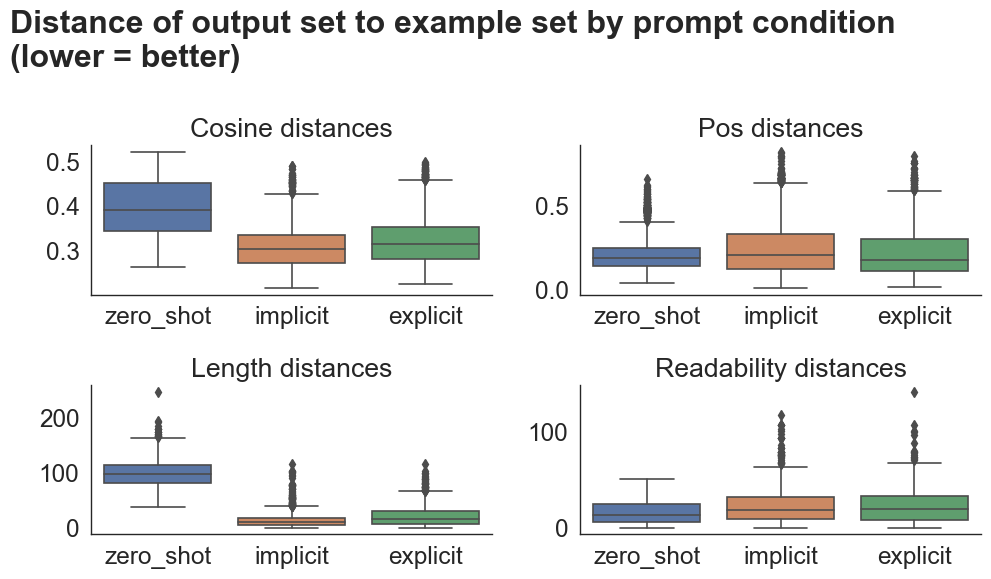

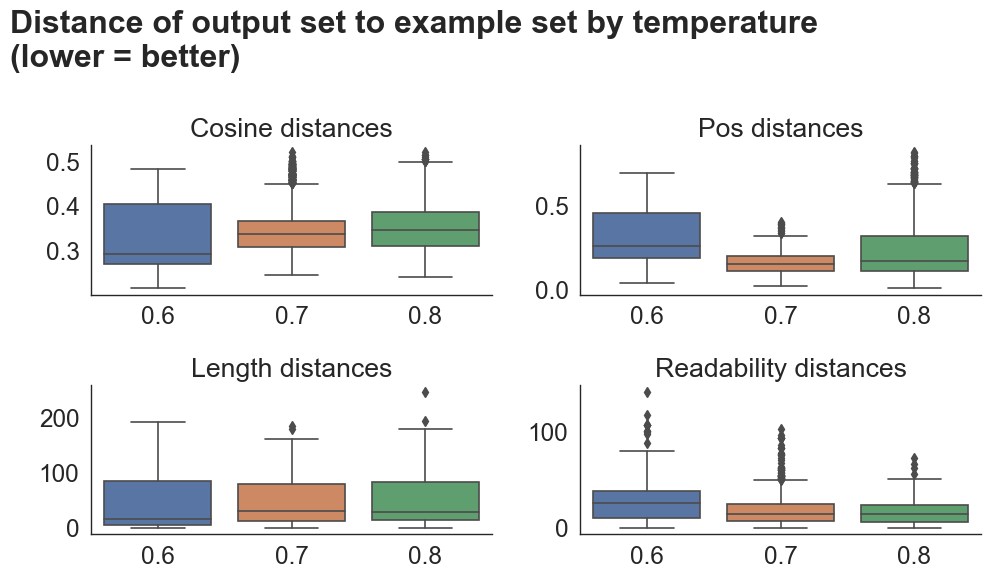

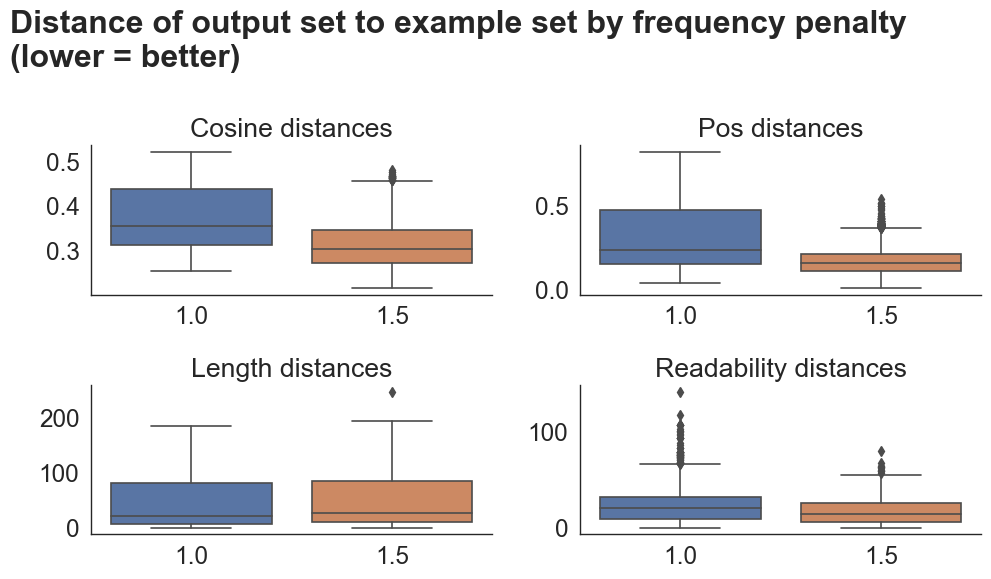

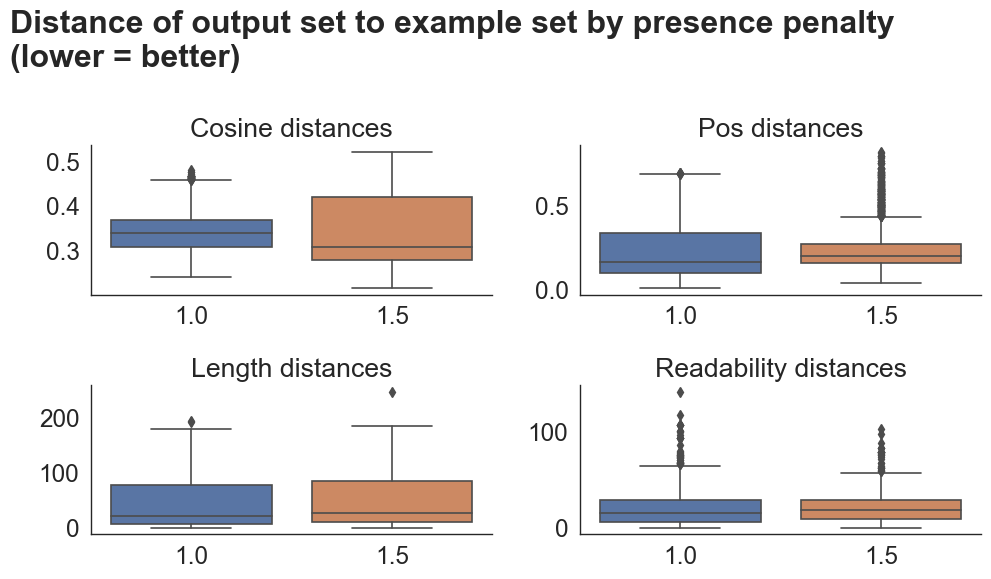

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt 

def make_aesthetic():
    sns.set(style='white', context='paper', font_scale=2)
    plt.rcParams.update({'font.family':'Arial'})

def make_graph(id_var):
    title_str = (id_var.replace("_", " ")).lower()
    make_aesthetic()
    distance_df = res[[id_var, 'cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']]
    melted_distance_df = distance_df.melt(id_vars=[id_var], var_name='distance_metric', value_name='distance')
    distance_metrics = ['cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=False)

    for ax, metric in zip(axes.flatten(), distance_metrics):
        sns.boxplot(x=id_var, y='distance', data=melted_distance_df[melted_distance_df['distance_metric'] == metric],  ax=ax)
        ax.set_title(metric.replace('_', ' ').capitalize())
        ax.set_xlabel('')
        ax.set_ylabel('')

    fig.suptitle('Distance of output set to example set by {}\n(lower = better)'.format(title_str), fontweight='bold', x=0, ha='left')

    plt.tight_layout()
    sns.despine()

    plt.savefig(f"{id_var}_difs.png", dpi=300)
    plt.show()

for iv in ivs:
    make_graph(iv)


# Parameters

In [6]:
res

,prompt_condition,trial_no,idx,examples,output_responses,n_examples,temperature,frequency_penalty,presence_penalty,output,...,output_pos_dists,example_pos_dists,output_length,example_length,output_readability,example_readability,cosine_distances,pos_distances,length_distances,readability_distances
0,zero_shot,0,0,"[small chair, BREAK A NUT, BUILD, A way to fil...",\n\n1. Use a brick as a paperweight to keep i...,4,0.6,1.0,1.0,[turn a brick into an artistic piece of home d...,...,"{'VB': 0.0722891566, 'DT': 0.09638554220000001...","{'JJ': 0.0625, 'NN': 0.125, 'NNP': 0.3125, 'TO...",19.75,4.00,68.3525,118.1775,NaN,0.466595,92.75,37.70
1,implicit,0,0,"[small chair, BREAK A NUT, BUILD, A way to fil...",\n- DIY plant stand \n- Bookend for a shelf\n-...,4,0.6,1.0,1.0,"[diy plant stand, bookend for a shelf, tool to...",...,"{'NN': 0.4666666667, 'VBP': 0.0666666667, 'IN'...","{'JJ': 0.0625, 'NN': 0.125, 'NNP': 0.3125, 'TO...",3.75,4.00,101.5125,118.1775,NaN,0.534379,2.25,15.91
2,explicit,0,0,"[small chair, BREAK A NUT, BUILD, A way to fil...",\n\n-A paperweight to keep documents in place ...,4,0.6,1.0,1.0,[an outdoor planter for small plants or flower...,...,"{'DT': 0.1923076923, 'JJ': 0.1153846154, 'NN':...","{'JJ': 0.0625, 'NN': 0.125, 'NNP': 0.3125, 'TO...",6.50,4.00,79.6850,118.1775,NaN,0.498976,22.00,52.45
3,zero_shot,1,0,"[small chair, BREAK A NUT, BUILD, A way to fil...",\n\n1. Use the brick to make a planter by fil...,4,0.6,1.0,1.0,[create a diy outdoor fireplace using several ...,...,"{'VB': 0.0649350649, 'DT': 0.1428571429, 'JJ':...","{'JJ': 0.0625, 'NN': 0.125, 'NNP': 0.3125, 'TO...",18.25,4.00,74.1025,118.1775,NaN,0.495625,81.25,27.72
4,implicit,1,0,"[small chair, BREAK A NUT, BUILD, A way to fil...",\n- A doorstop \n- An impromptu planter box \n...,4,0.6,1.0,1.0,"[use as a weight to exercise with, a doorstop,...",...,"{'NN': 0.5, 'IN': 0.125, 'DT': 0.25, 'TO': 0.0...","{'JJ': 0.0625, 'NN': 0.125, 'NNP': 0.3125, 'TO...",4.00,4.00,94.9125,118.1775,NaN,0.556704,4.75,25.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,implicit,98,11,"[Weights for working out, painting them to mak...",\n- Use as a door stop or bookend.\n- Make a ...,4,0.8,1.5,1.5,"[make a makeshift bird bath or fountain., crea...",...,"{'VB': 0.1034482759, 'DT': 0.1034482759, 'NN':...","{'NNS': 0.0952380952, 'IN': 0.0952380952, 'VBG...",6.25,5.25,86.2825,93.6450,NaN,0.263173,8.25,6.46
3596,explicit,98,11,"[Weights for working out, painting them to mak...",\n \n- Use to hold down a picnic blanket on wi...,4,0.8,1.5,1.5,[paint and stack them together for an outdoor ...,...,"{'NN': 0.33333333330000003, 'CC': 0.0256410256...","{'NNS': 0.0952380952, 'IN': 0.0952380952, 'VBG...",9.50,5.25,76.6425,93.6450,NaN,0.198121,25.75,14.89
3597,zero_shot,99,11,"[Weights for working out, painting them to mak...",\n\n1. Create a garden planter box by stacking...,4,0.8,1.5,1.5,[make an attractive wall feature out of multip...,...,"{'VB': 0.0202020202, 'DT': 0.0909090909, 'JJ':...","{'NNS': 0.0952380952, 'IN': 0.0952380952, 'VBG...",23.50,5.25,56.0850,93.6450,NaN,0.218079,110.25,35.83
3598,implicit,99,11,"[Weights for working out, painting them to mak...",\n- Use a brick as a paperweight \n- Turn them...,4,0.8,1.5,1.5,[turn them into stepping stones for the garden...,...,"{'VB': 0.0714285714, 'PRP': 0.0714285714, 'IN'...","{'NNS': 0.0952380952, 'IN': 0.0952380952, 'VBG...",7.00,5.25,91.8675,93.6450,NaN,0.171263,9.50,24.02


In [134]:
res.columns

Index(['prompt_condition', 'trial_no', 'idx', 'examples', 'output_responses',
       'n_examples', 'temperature', 'frequency_penalty', 'presence_penalty',
       'output', 'output_embeddings', 'example_embeddings',
       'output_bert_embeddings', 'example_bert_embeddings', 'output_pos_dists',
       'example_pos_dists', 'output_length', 'example_length',
       'output_readability', 'example_readability', 'cosine_old_distances',
       'cosine_distances', 'pos_distances', 'length_distances',
       'readability_distances'],
      dtype='object')